# Etap 2: Comprehensive Data Visualization

This notebook provides detailed visualizations of the Airbnb data at different processing stages:
1. Raw data analysis with missing value patterns
2. Processed data distributions 
3. Target variable analysis
4. Feature relationships and correlations

Goal: Understand data quality issues and inform imputation strategies before modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting parameters
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Raw and Processed Data

In [2]:
# Load processed datasets
processed_data_dir = '../data/processed/etap2/'

print("Loading processed datasets...")
listings_df = pd.read_pickle(processed_data_dir + 'listings_e2_df.pkl')
calendar_df = pd.read_pickle(processed_data_dir + 'calendar_e2_df.pkl')
reviews_df = pd.read_pickle(processed_data_dir + 'reviews_e2_df.pkl')

print(f"Listings: {listings_df.shape}")
print(f"Calendar: {calendar_df.shape}")
print(f"Reviews: {reviews_df.shape}")

# Load analysis results if available
try:
    reliable_listings = pd.read_pickle(processed_data_dir + 'analysis/reliable_listings.pkl')
    print(f"Reliable listings: {reliable_listings.shape}")
    has_reliable_data = True
except FileNotFoundError:
    print("Reliable listings data not found - will generate it")
    has_reliable_data = False

Loading processed datasets...
Listings: (47572, 75)
Calendar: (17363102, 5)
Reviews: (953651, 7)
Reliable listings: (95142, 14)


## 2. Missing Value Analysis - Critical for Imputation Strategy

In [3]:
# Calculate missing value percentages for key features
key_features = [
    'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
    'bedrooms', 'beds', 'bathrooms_text', 'price', 'minimum_nights',
    'availability_365', 'number_of_reviews', 'review_scores_rating',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'host_is_superhost', 'host_identity_verified', 'instant_bookable',
    'latitude', 'longitude'
]

# Filter to features that actually exist
available_features = [f for f in key_features if f in listings_df.columns]

# Calculate missing percentages
missing_data = []
for feature in available_features:
    missing_count = listings_df[feature].isna().sum()
    missing_pct = (missing_count / len(listings_df)) * 100
    missing_data.append({
        'feature': feature,
        'missing_count': missing_count,
        'missing_percentage': missing_pct,
        'available_count': len(listings_df) - missing_count
    })

missing_df = pd.DataFrame(missing_data).sort_values('missing_percentage', ascending=False)
print("Missing value analysis:")
print(missing_df.head(15))

Missing value analysis:
                        feature  missing_count  missing_percentage  \
5                          beds          16236           34.129320   
7                         price          16189           34.030522   
16       review_scores_location          12272           25.796687   
17          review_scores_value          12271           25.794585   
14        review_scores_checkin          12271           25.794585   
15  review_scores_communication          12260           25.771462   
12       review_scores_accuracy          12256           25.763054   
13    review_scores_cleanliness          12253           25.756748   
11         review_scores_rating          12247           25.744135   
4                      bedrooms           6213           13.060203   
18            host_is_superhost            884            1.858236   
6                bathrooms_text             76            0.159758   
19       host_identity_verified              7            0.014715

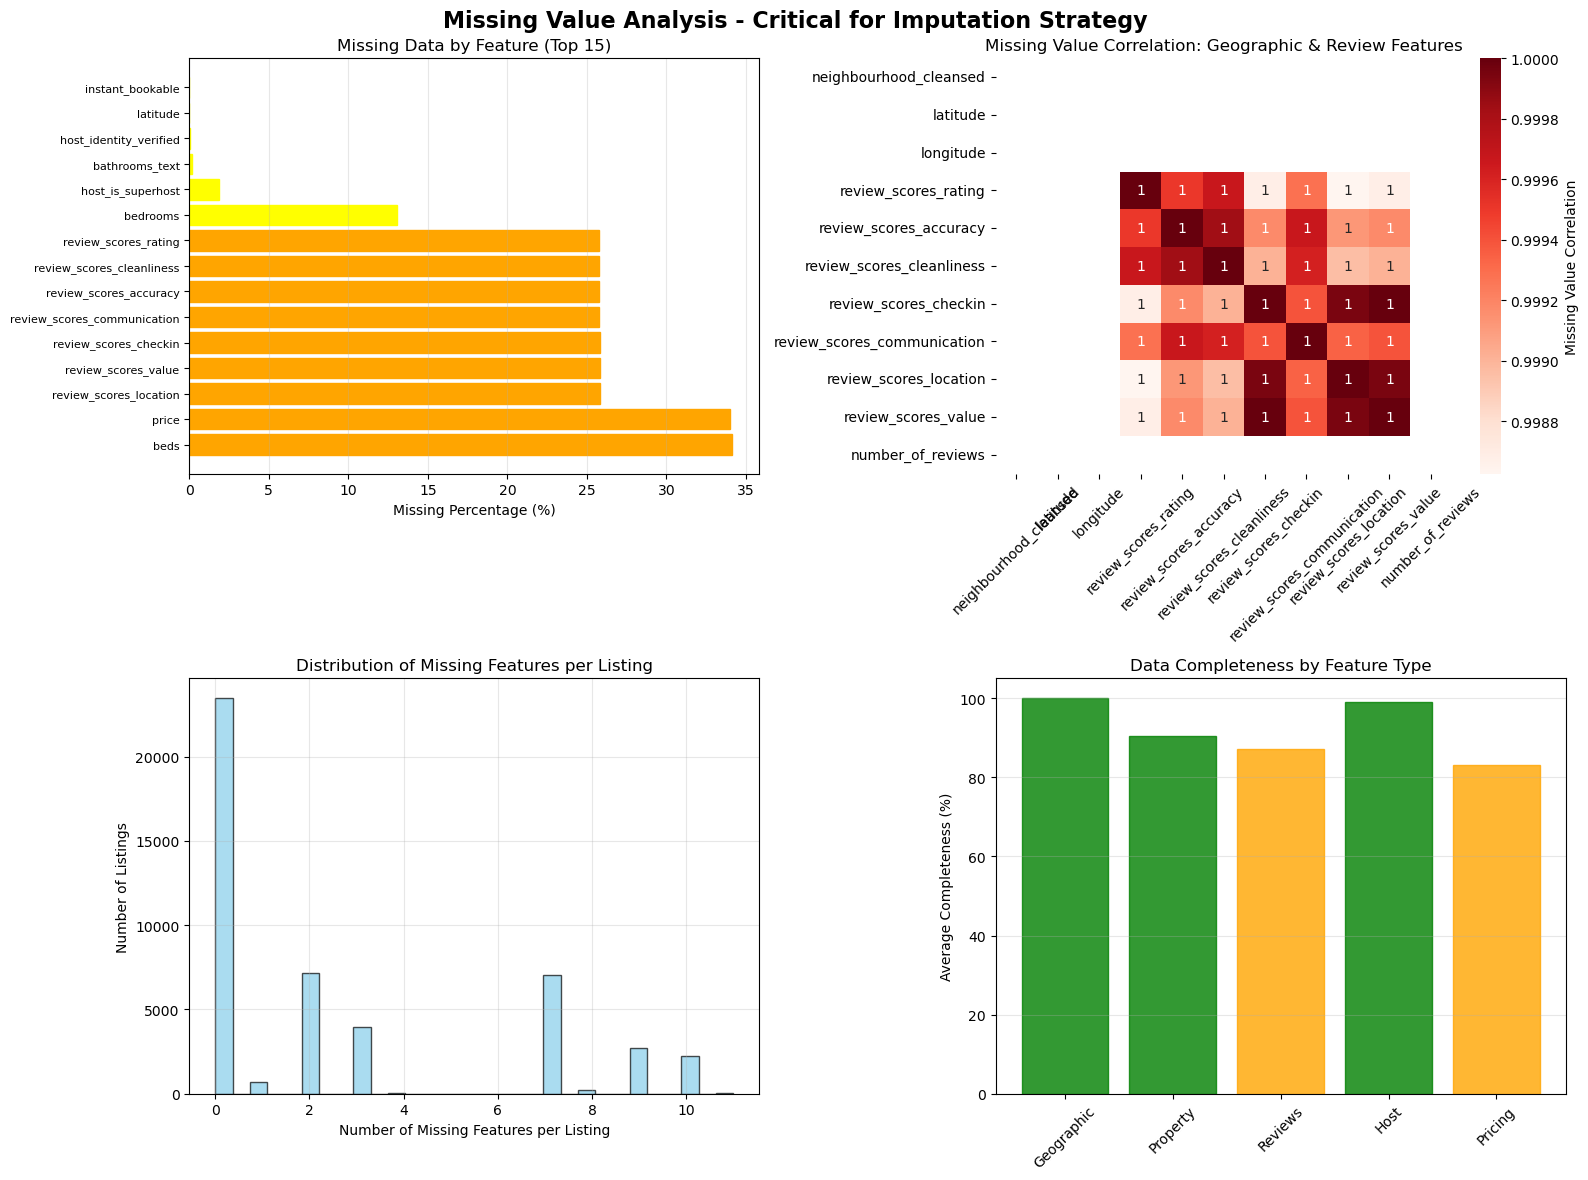


Imputation Strategy Recommendations:
🔴 >50% missing: Consider dropping or use domain knowledge
🟠 20-50% missing: Advanced imputation (KNN, Iterative)
🟡 <20% missing: Simple imputation (median, mode)


In [4]:
# Visualize missing value patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Missing Value Analysis - Critical for Imputation Strategy', fontsize=16, fontweight='bold')

# Missing value percentages (top 15)
top_missing = missing_df.head(15)
bars = axes[0,0].barh(range(len(top_missing)), top_missing['missing_percentage'])
axes[0,0].set_yticks(range(len(top_missing)))
axes[0,0].set_yticklabels(top_missing['feature'], fontsize=8)
axes[0,0].set_xlabel('Missing Percentage (%)')
axes[0,0].set_title('Missing Data by Feature (Top 15)')
axes[0,0].grid(axis='x', alpha=0.3)

# Color bars by severity
for i, (idx, row) in enumerate(top_missing.iterrows()):
    if row['missing_percentage'] > 50:
        bars[i].set_color('red')
    elif row['missing_percentage'] > 20:
        bars[i].set_color('orange')
    else:
        bars[i].set_color('yellow')

# Missing value heatmap for geographic and review features
geo_review_features = ['neighbourhood_cleansed', 'latitude', 'longitude',
                      'review_scores_rating', 'review_scores_accuracy',
                      'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location',
                      'review_scores_value', 'number_of_reviews']
geo_review_available = [f for f in geo_review_features if f in listings_df.columns]

if geo_review_available:
    missing_matrix = listings_df[geo_review_available].isna()
    sns.heatmap(missing_matrix.corr(), annot=True, cmap='Reds',
                ax=axes[0,1], cbar_kws={'label': 'Missing Value Correlation'})
    axes[0,1].set_title('Missing Value Correlation: Geographic & Review Features')
    axes[0,1].tick_params(axis='x', rotation=45)

# Distribution of missing values per listing
missing_per_listing = listings_df[available_features].isna().sum(axis=1)
axes[1,0].hist(missing_per_listing, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Number of Missing Features per Listing')
axes[1,0].set_ylabel('Number of Listings')
axes[1,0].set_title('Distribution of Missing Features per Listing')
axes[1,0].grid(alpha=0.3)

# Completeness by feature type
feature_types = {
    'Geographic': ['neighbourhood_cleansed', 'latitude', 'longitude'],
    'Property': ['property_type', 'room_type', 'accommodates', 'bedrooms', 'beds'],
    'Reviews': ['review_scores_rating', 'number_of_reviews'],
    'Host': ['host_is_superhost', 'host_identity_verified'],
    'Pricing': ['price', 'minimum_nights']
}

completeness_by_type = {}
for ftype, features in feature_types.items():
    available_type_features = [f for f in features if f in listings_df.columns]
    if available_type_features:
        avg_completeness = 100 - listings_df[available_type_features].isna().mean().mean() * 100
        completeness_by_type[ftype] = avg_completeness

if completeness_by_type:
    types = list(completeness_by_type.keys())
    completeness = list(completeness_by_type.values())
    bars = axes[1,1].bar(types, completeness, alpha=0.8)
    axes[1,1].set_ylabel('Average Completeness (%)')
    axes[1,1].set_title('Data Completeness by Feature Type')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(axis='y', alpha=0.3)

    # Color bars by completeness level
    for bar, comp in zip(bars, completeness):
        if comp > 90:
            bar.set_color('green')
        elif comp > 70:
            bar.set_color('orange')
        else:
            bar.set_color('red')

plt.tight_layout()
plt.show()

print("\nImputation Strategy Recommendations:")
print("🔴 >50% missing: Consider dropping or use domain knowledge")
print("🟠 20-50% missing: Advanced imputation (KNN, Iterative)")
print("🟡 <20% missing: Simple imputation (median, mode)")

## 3. Neighborhood Analysis - Critical Missing Field

NEIGHBOURHOOD_CLEANSED ANALYSIS
Missing neighbourhoods: 0 (0.0%)
Missing neighbourhoods with coordinates: 0
Can potentially reverse geocode: nan%

Top 10 neighbourhoods:
Westminster               5392
Tower Hamlets             3817
Hackney                   3208
Camden                    3149
Kensington and Chelsea    3134
Southwark                 2665
Islington                 2526
Wandsworth                2510
Lambeth                   2470
Hammersmith and Fulham    1971
Name: neighbourhood_cleansed, dtype: int64


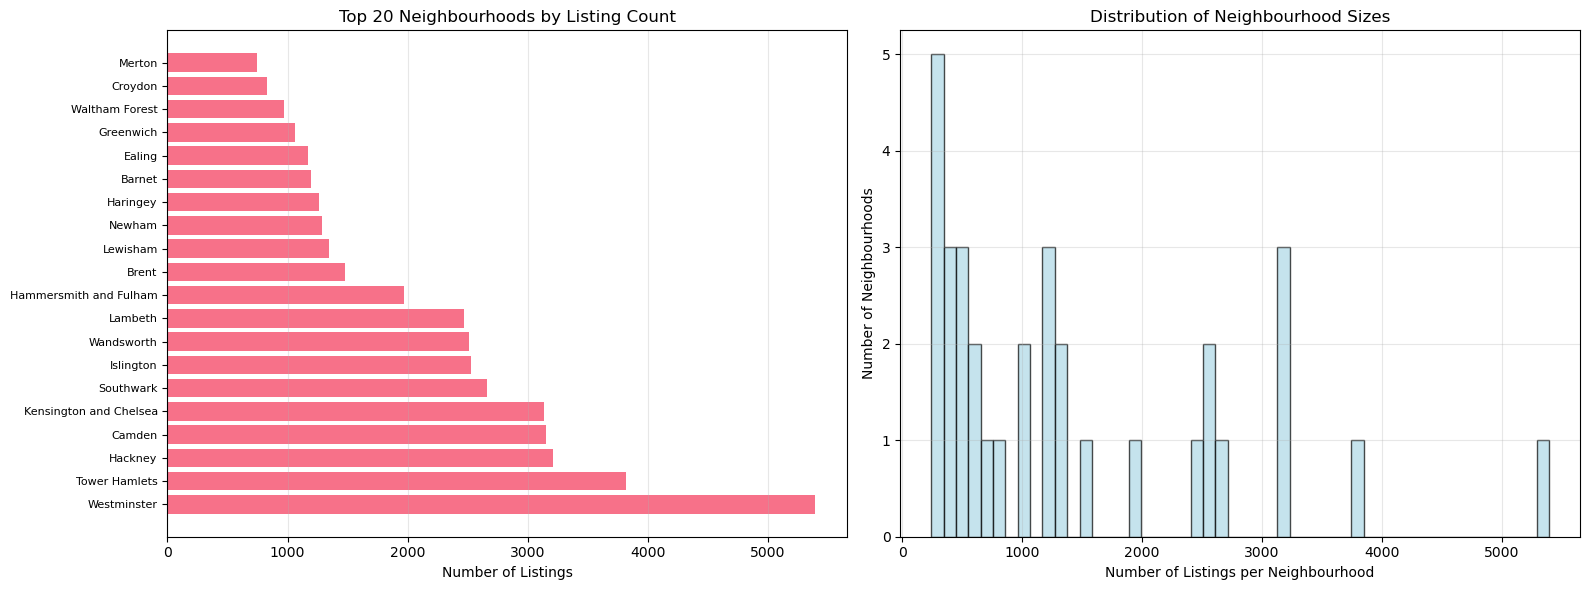

In [5]:
# Analyze neighbourhood_cleansed missing pattern
print("NEIGHBOURHOOD_CLEANSED ANALYSIS")
print("=" * 40)

if 'neighbourhood_cleansed' in listings_df.columns:
    neighbourhood_missing = listings_df['neighbourhood_cleansed'].isna().sum()
    neighbourhood_missing_pct = neighbourhood_missing / len(listings_df) * 100

    print(f"Missing neighbourhoods: {neighbourhood_missing:,} ({neighbourhood_missing_pct:.1f}%)")

    # Check if we have coordinates for missing neighbourhoods
    if 'latitude' in listings_df.columns and 'longitude' in listings_df.columns:
        missing_neighbourhood_mask = listings_df['neighbourhood_cleansed'].isna()
        coords_available_for_missing = (
            listings_df.loc[missing_neighbourhood_mask, 'latitude'].notna() &
            listings_df.loc[missing_neighbourhood_mask, 'longitude'].notna()
        ).sum()

        print(f"Missing neighbourhoods with coordinates: {coords_available_for_missing:,}")
        print(f"Can potentially reverse geocode: {coords_available_for_missing / neighbourhood_missing * 100:.1f}%")

    # Show neighbourhood distribution
    if neighbourhood_missing < len(listings_df):
        neighbourhood_counts = listings_df['neighbourhood_cleansed'].value_counts()
        print(f"\nTop 10 neighbourhoods:")
        print(neighbourhood_counts.head(10))

        # Visualize neighbourhood distribution
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Top 20 neighbourhoods
        top_20_neighbourhoods = neighbourhood_counts.head(20)
        axes[0].barh(range(len(top_20_neighbourhoods)), top_20_neighbourhoods.values)
        axes[0].set_yticks(range(len(top_20_neighbourhoods)))
        axes[0].set_yticklabels(top_20_neighbourhoods.index, fontsize=8)
        axes[0].set_xlabel('Number of Listings')
        axes[0].set_title('Top 20 Neighbourhoods by Listing Count')
        axes[0].grid(axis='x', alpha=0.3)

        # Distribution of neighbourhood sizes
        axes[1].hist(neighbourhood_counts.values, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
        axes[1].set_xlabel('Number of Listings per Neighbourhood')
        axes[1].set_ylabel('Number of Neighbourhoods')
        axes[1].set_title('Distribution of Neighbourhood Sizes')
        axes[1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
else:
    print("neighbourhood_cleansed column not found")

## 4. Geographic Distribution Analysis

GEOGRAPHIC DATA ANALYSIS
Valid coordinates: 47,572 (100.0%)
Latitude range: 51.2959 to 51.6816
Longitude range: -0.4961 to 0.2960


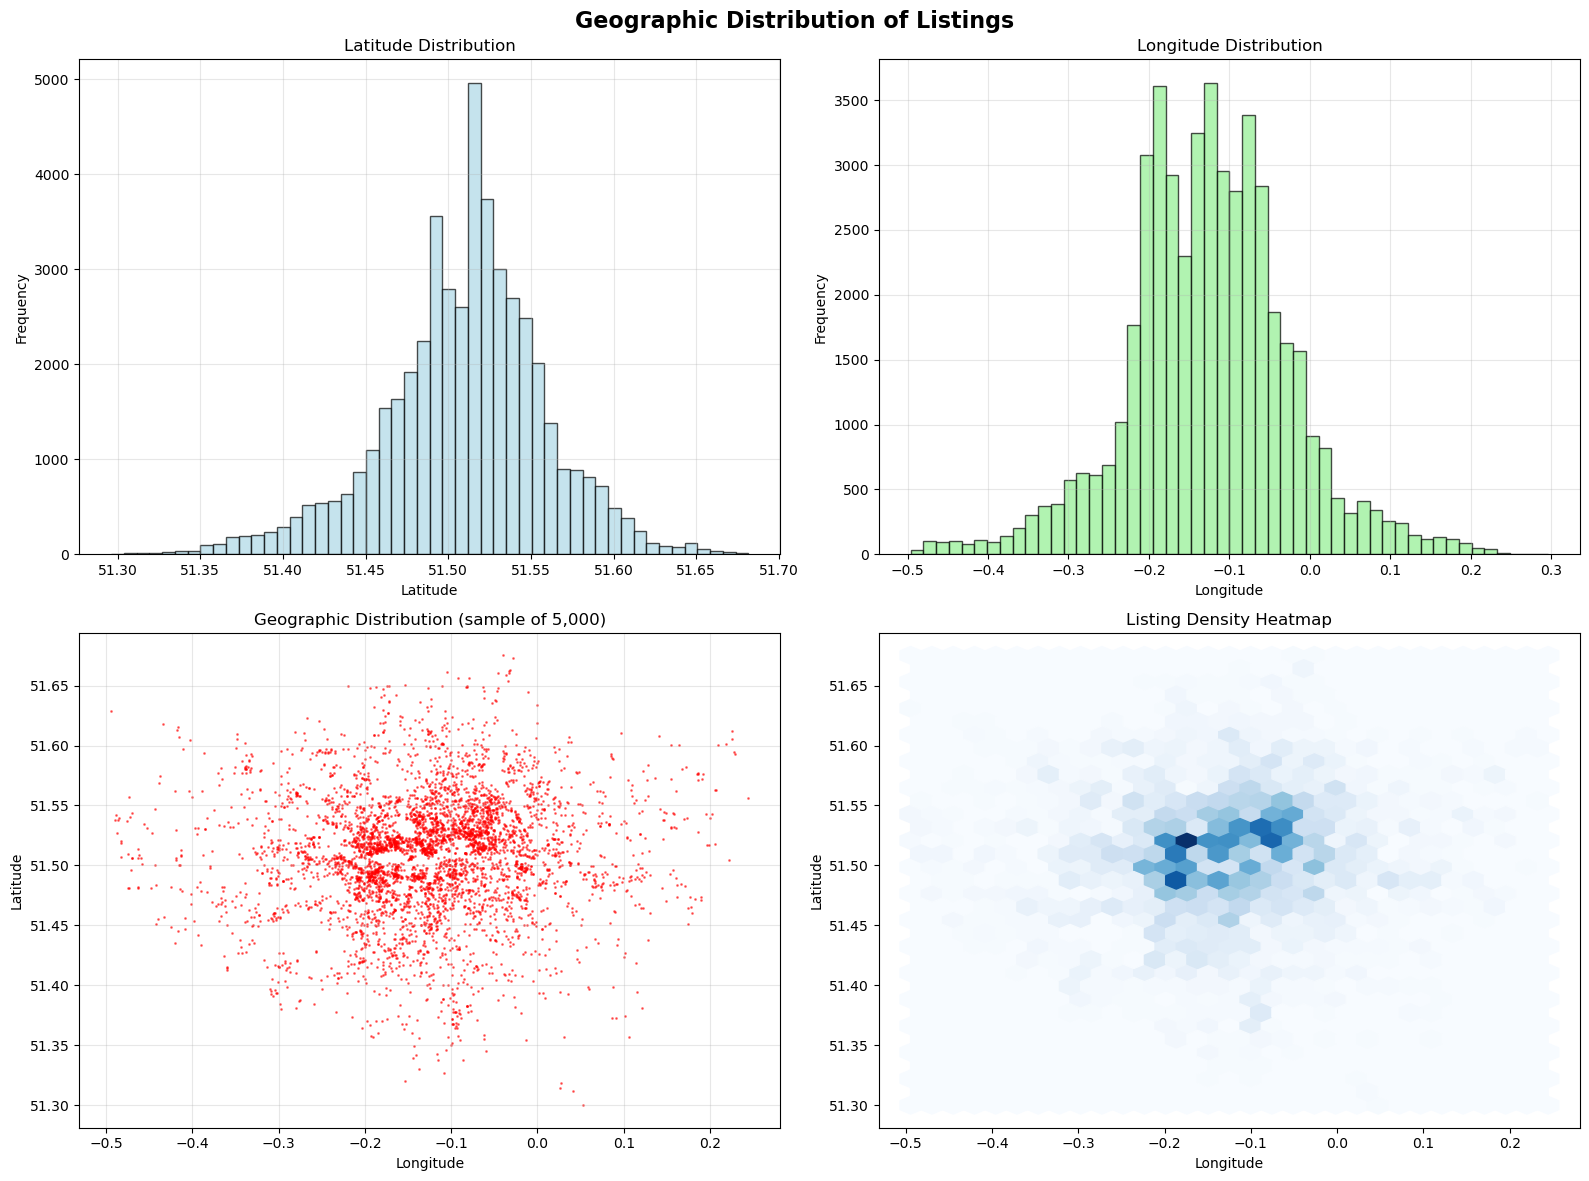

In [6]:
# Analyze geographic data
if 'latitude' in listings_df.columns and 'longitude' in listings_df.columns:
    print("GEOGRAPHIC DATA ANALYSIS")
    print("=" * 30)

    valid_coords = listings_df[['latitude', 'longitude']].dropna()
    print(f"Valid coordinates: {len(valid_coords):,} ({len(valid_coords)/len(listings_df)*100:.1f}%)")

    if len(valid_coords) > 0:
        print(f"Latitude range: {valid_coords['latitude'].min():.4f} to {valid_coords['latitude'].max():.4f}")
        print(f"Longitude range: {valid_coords['longitude'].min():.4f} to {valid_coords['longitude'].max():.4f}")

        # Create geographic visualizations
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Geographic Distribution of Listings', fontsize=16, fontweight='bold')

        # Latitude distribution
        axes[0,0].hist(valid_coords['latitude'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
        axes[0,0].set_xlabel('Latitude')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Latitude Distribution')
        axes[0,0].grid(alpha=0.3)

        # Longitude distribution
        axes[0,1].hist(valid_coords['longitude'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0,1].set_xlabel('Longitude')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].set_title('Longitude Distribution')
        axes[0,1].grid(alpha=0.3)

        # Scatter plot of coordinates
        sample_size = min(5000, len(valid_coords))
        sample_coords = valid_coords.sample(n=sample_size, random_state=42)
        axes[1,0].scatter(sample_coords['longitude'], sample_coords['latitude'],
                         alpha=0.5, s=1, color='red')
        axes[1,0].set_xlabel('Longitude')
        axes[1,0].set_ylabel('Latitude')
        axes[1,0].set_title(f'Geographic Distribution (sample of {sample_size:,})')
        axes[1,0].grid(alpha=0.3)

        # Density plot
        axes[1,1].hexbin(sample_coords['longitude'], sample_coords['latitude'],
                        gridsize=30, cmap='Blues')
        axes[1,1].set_xlabel('Longitude')
        axes[1,1].set_ylabel('Latitude')
        axes[1,1].set_title('Listing Density Heatmap')

        plt.tight_layout()
        plt.show()
else:
    print("Geographic coordinates not available")

## 5. Property Features Distribution

PROPERTY FEATURES ANALYSIS


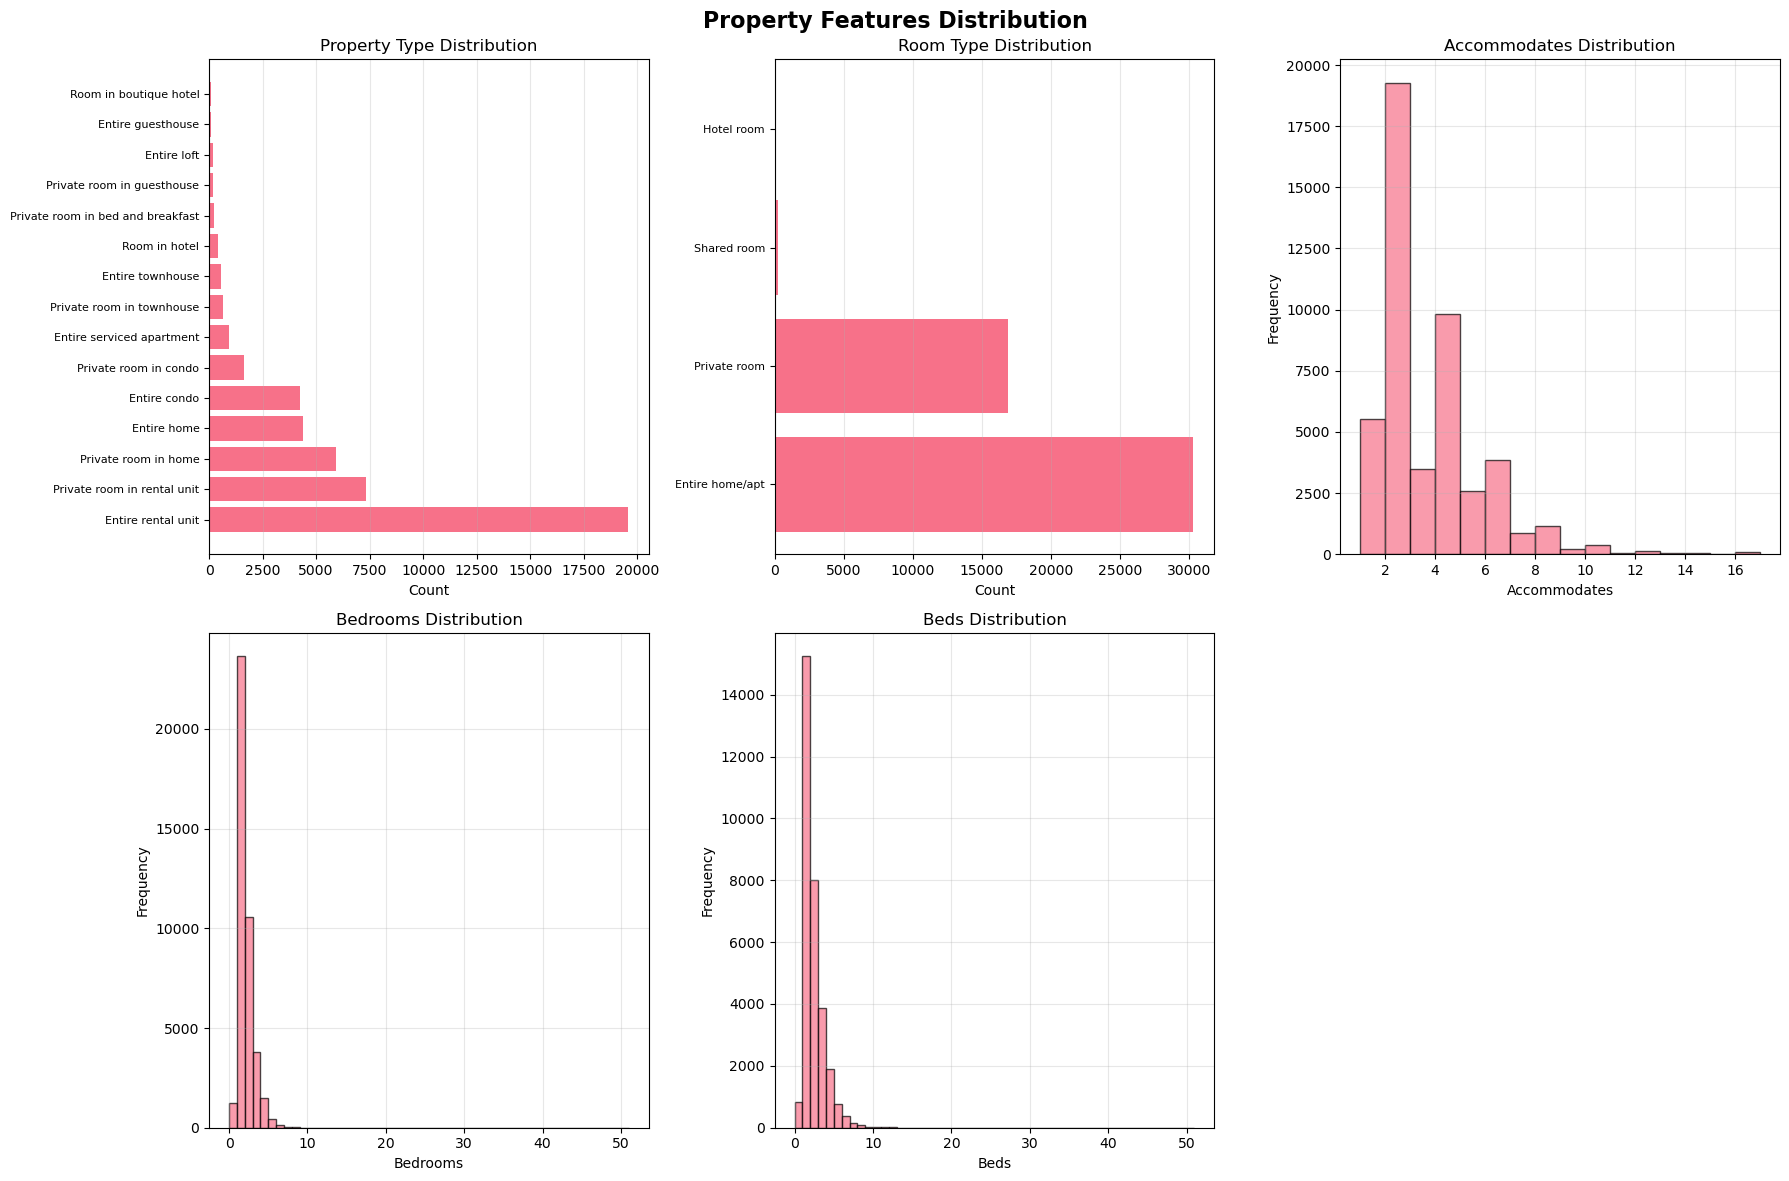


Accommodates statistics:
count    47572.000000
mean         3.274699
std          2.050928
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

Bedrooms statistics:
count    41359.000000
mean         1.597307
std          1.186042
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         50.000000
Name: bedrooms, dtype: float64

Beds statistics:
count    31336.000000
mean         1.902062
std          1.421646
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         50.000000
Name: beds, dtype: float64


In [7]:
# Analyze key property features
print("PROPERTY FEATURES ANALYSIS")
print("=" * 35)

property_features = ['property_type', 'room_type', 'accommodates', 'bedrooms', 'beds']
available_property_features = [f for f in property_features if f in listings_df.columns]

if available_property_features:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Property Features Distribution', fontsize=16, fontweight='bold')

    plot_idx = 0

    # Categorical features
    categorical_features = ['property_type', 'room_type']
    for feature in categorical_features:
        if feature in listings_df.columns:
            row, col = plot_idx // 3, plot_idx % 3
            if plot_idx < 6:
                feature_counts = listings_df[feature].value_counts().head(15)
                axes[row, col].barh(range(len(feature_counts)), feature_counts.values)
                axes[row, col].set_yticks(range(len(feature_counts)))
                axes[row, col].set_yticklabels(feature_counts.index, fontsize=8)
                axes[row, col].set_xlabel('Count')
                axes[row, col].set_title(f'{feature.replace("_", " ").title()} Distribution')
                axes[row, col].grid(axis='x', alpha=0.3)
                plot_idx += 1

    # Numerical features
    numerical_features = ['accommodates', 'bedrooms', 'beds']
    for feature in numerical_features:
        if feature in listings_df.columns:
            row, col = plot_idx // 3, plot_idx % 3
            if plot_idx < 6:
                feature_data = pd.to_numeric(listings_df[feature], errors='coerce').dropna()
                if len(feature_data) > 0:
                    axes[row, col].hist(feature_data, bins=range(int(feature_data.min()),
                                       int(feature_data.max()) + 2),
                                       alpha=0.7, edgecolor='black')
                    axes[row, col].set_xlabel(feature.replace("_", " ").title())
                    axes[row, col].set_ylabel('Frequency')
                    axes[row, col].set_title(f'{feature.replace("_", " ").title()} Distribution')
                    axes[row, col].grid(alpha=0.3)
                plot_idx += 1

    # Hide unused subplots
    for i in range(plot_idx, 6):
        row, col = i // 3, i % 3
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    for feature in numerical_features:
        if feature in listings_df.columns:
            feature_data = pd.to_numeric(listings_df[feature], errors='coerce')
            print(f"\n{feature.replace('_', ' ').title()} statistics:")
            print(feature_data.describe())

## 6. Review and Rating Analysis

REVIEW AND RATING ANALYSIS
number_of_reviews: 0.0% missing
review_scores_rating: 25.7% missing
review_scores_accuracy: 25.8% missing
review_scores_cleanliness: 25.8% missing
review_scores_checkin: 25.8% missing
review_scores_communication: 25.8% missing
review_scores_location: 25.8% missing
review_scores_value: 25.8% missing


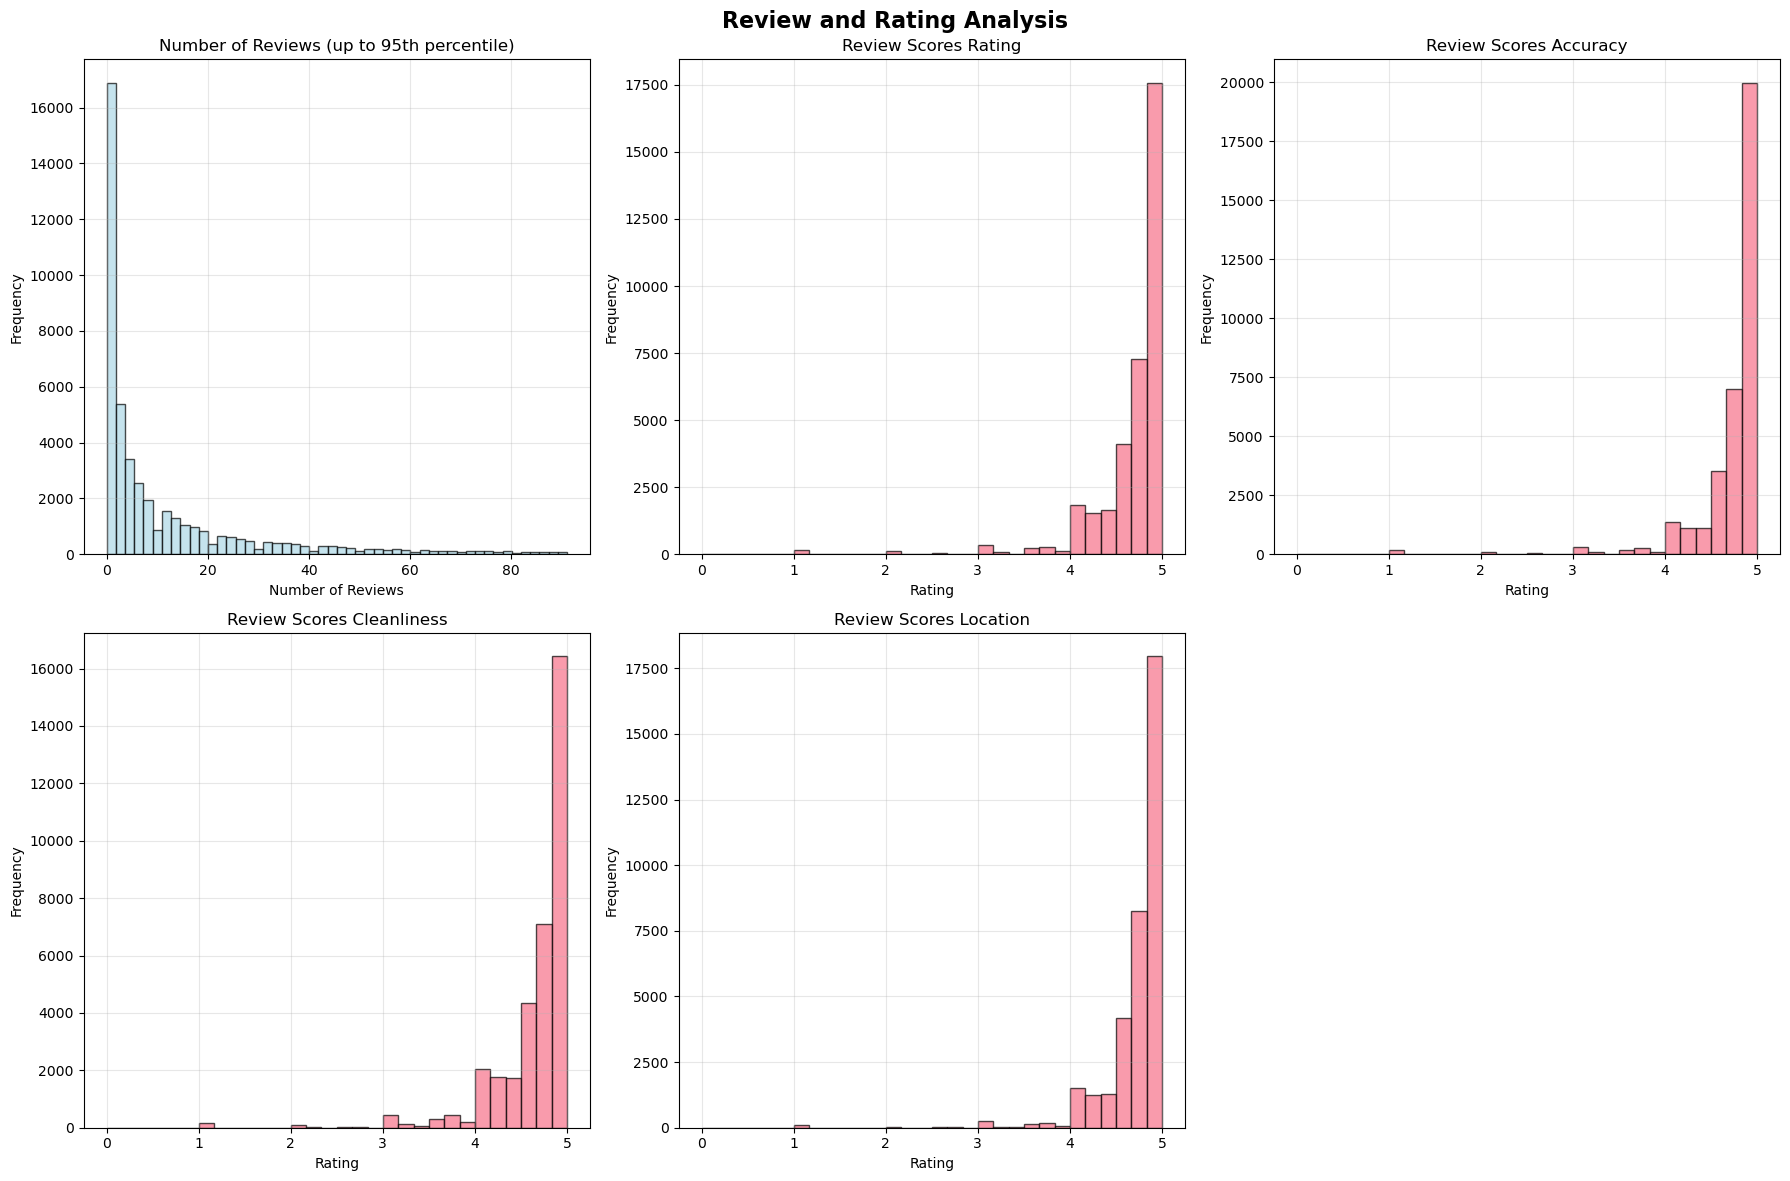

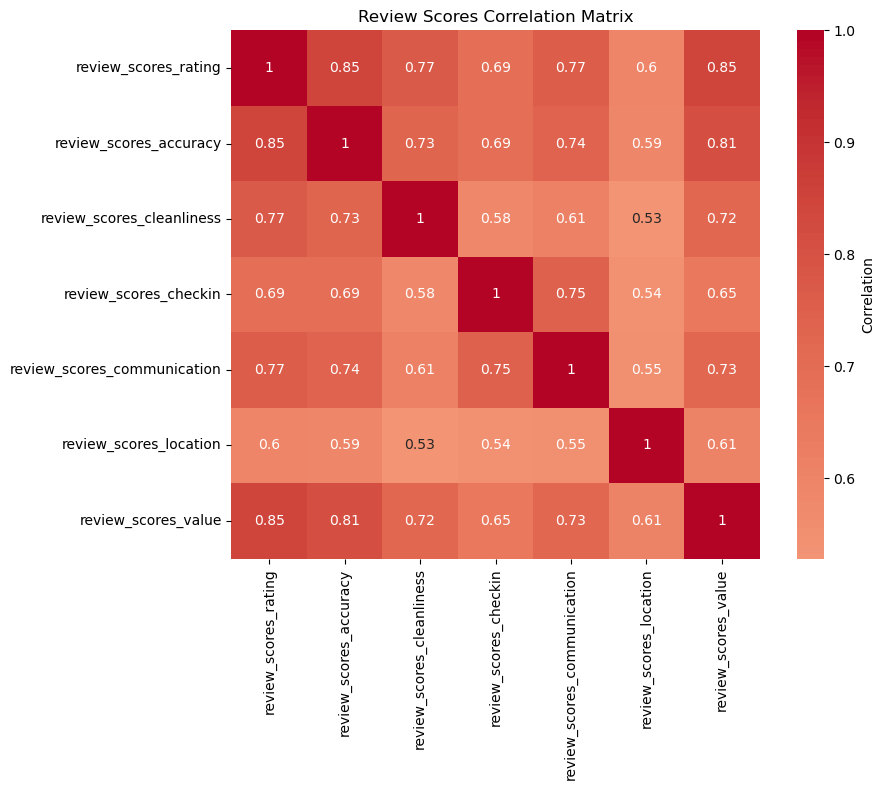

In [8]:
# Analyze review and rating data
print("REVIEW AND RATING ANALYSIS")
print("=" * 35)

review_features = ['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
                  'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location',
                  'review_scores_value']
available_review_features = [f for f in review_features if f in listings_df.columns]

if available_review_features:
    # Calculate missing percentages for review features
    review_missing = {}
    for feature in available_review_features:
        missing_pct = listings_df[feature].isna().mean() * 100
        review_missing[feature] = missing_pct
        print(f"{feature}: {missing_pct:.1f}% missing")

    # Visualize review features
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Review and Rating Analysis', fontsize=16, fontweight='bold')

    plot_idx = 0

    # Number of reviews
    if 'number_of_reviews' in listings_df.columns:
        review_counts = pd.to_numeric(listings_df['number_of_reviews'], errors='coerce')
        if review_counts.notna().sum() > 0:
            axes[0, 0].hist(review_counts[review_counts <= review_counts.quantile(0.95)].dropna(),
                           bins=50, alpha=0.7, color='lightblue', edgecolor='black')
            axes[0, 0].set_xlabel('Number of Reviews')
            axes[0, 0].set_ylabel('Frequency')
            axes[0, 0].set_title('Number of Reviews (up to 95th percentile)')
            axes[0, 0].grid(alpha=0.3)

    # Review scores
    review_score_features = ['review_scores_rating', 'review_scores_accuracy',
                            'review_scores_cleanliness', 'review_scores_location']

    for i, feature in enumerate(review_score_features):
        if feature in listings_df.columns and i < 5:
            row, col = (i + 1) // 3, (i + 1) % 3
            scores = pd.to_numeric(listings_df[feature], errors='coerce').dropna()
            if len(scores) > 0:
                axes[row, col].hist(scores, bins=30, alpha=0.7, edgecolor='black')
                axes[row, col].set_xlabel('Rating')
                axes[row, col].set_ylabel('Frequency')
                axes[row, col].set_title(f'{feature.replace("_", " ").title()}')
                axes[row, col].grid(alpha=0.3)

    # Hide unused subplot
    axes[1, 2].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Correlation between review scores
    review_score_cols = [f for f in available_review_features if 'review_scores' in f]
    if len(review_score_cols) > 1:
        review_corr_data = listings_df[review_score_cols].apply(pd.to_numeric, errors='coerce')
        correlation_matrix = review_corr_data.corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, cbar_kws={'label': 'Correlation'})
        plt.title('Review Scores Correlation Matrix')
        plt.tight_layout()
        plt.show()

## 7. Calendar Data Analysis - Revenue Calculation Foundation

CALENDAR DATA ANALYSIS
Calendar data shape: (17363102, 5)
Date range: 2024-12-11 00:00:00 to 2025-12-21 00:00:00
Total days covered: 376

Price data availability: 17,363,102 (100.0%)
Price range: £0 - £80000
Price median: £120


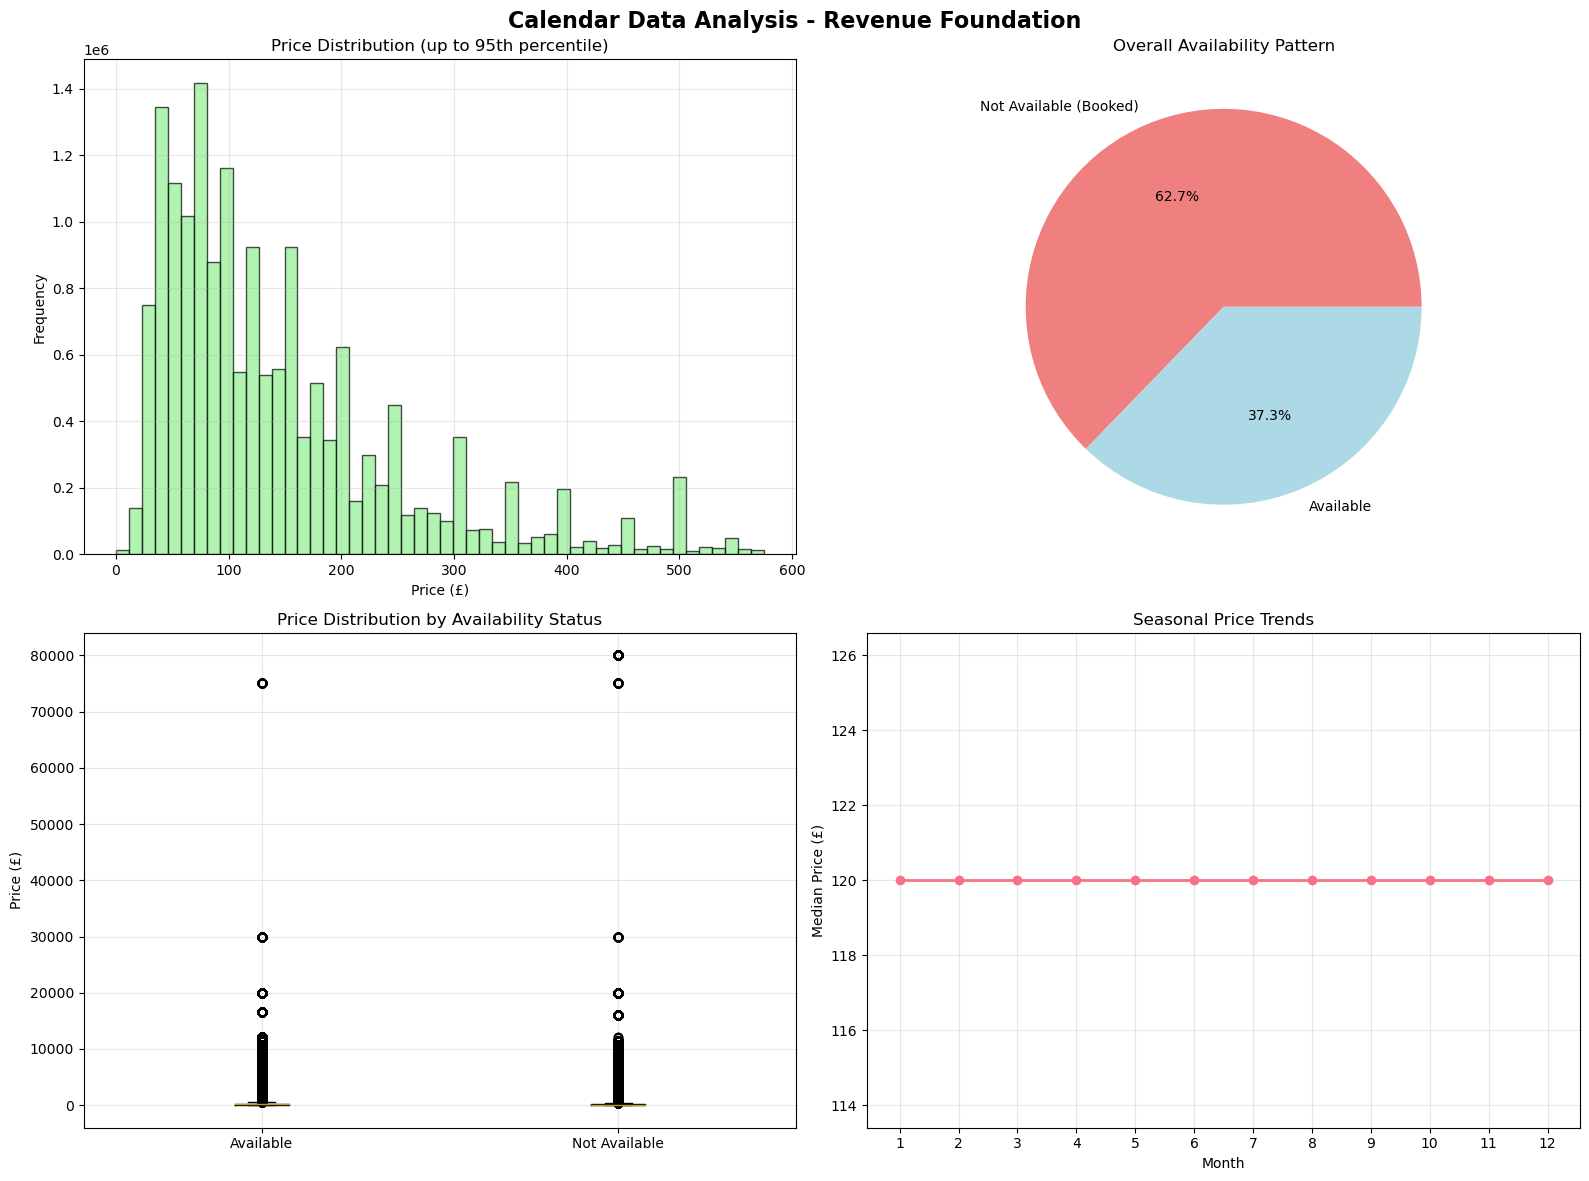

In [9]:
# Analyze calendar data for revenue calculations
print("CALENDAR DATA ANALYSIS")
print("=" * 30)

print(f"Calendar data shape: {calendar_df.shape}")
print(f"Date range: {calendar_df['date'].min()} to {calendar_df['date'].max()}")
print(f"Total days covered: {(calendar_df['date'].max() - calendar_df['date'].min()).days + 1}")

# Price analysis
if 'price_cleaned' in calendar_df.columns:
    valid_prices = calendar_df['price_cleaned'].dropna()
    print(f"\nPrice data availability: {len(valid_prices):,} ({len(valid_prices)/len(calendar_df)*100:.1f}%)")
    print(f"Price range: £{valid_prices.min():.0f} - £{valid_prices.max():.0f}")
    print(f"Price median: £{valid_prices.median():.0f}")

    # Visualize calendar data
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Calendar Data Analysis - Revenue Foundation', fontsize=16, fontweight='bold')

    # Price distribution
    axes[0, 0].hist(valid_prices[valid_prices <= valid_prices.quantile(0.95)],
                   bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 0].set_xlabel('Price (£)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Price Distribution (up to 95th percentile)')
    axes[0, 0].grid(alpha=0.3)

    # Availability pattern
    availability_counts = calendar_df['available'].value_counts()
    axes[0, 1].pie(availability_counts.values, labels=['Not Available (Booked)', 'Available'],
                  autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
    axes[0, 1].set_title('Overall Availability Pattern')

    # Price by availability status
    if calendar_df['available'].notna().sum() > 0:
        price_by_availability = []
        labels = []
        for available_status in [True, False]:
            subset_prices = calendar_df[calendar_df['available'] == available_status]['price_cleaned'].dropna()
            if len(subset_prices) > 0:
                price_by_availability.append(subset_prices)
                labels.append('Available' if available_status else 'Not Available')

        if price_by_availability:
            axes[1, 0].boxplot(price_by_availability, labels=labels)
            axes[1, 0].set_ylabel('Price (£)')
            axes[1, 0].set_title('Price Distribution by Availability Status')
            axes[1, 0].grid(alpha=0.3)

    # Monthly price trends
    calendar_df['month'] = calendar_df['date'].dt.month
    monthly_prices = calendar_df.groupby('month')['price_cleaned'].median()
    axes[1, 1].plot(monthly_prices.index, monthly_prices.values, marker='o', linewidth=2)
    axes[1, 1].set_xlabel('Month')
    axes[1, 1].set_ylabel('Median Price (£)')
    axes[1, 1].set_title('Seasonal Price Trends')
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].set_xticks(range(1, 13))

    plt.tight_layout()
    plt.show()

## 8. Revenue Metrics Analysis (if available)

REVENUE METRICS ANALYSIS
Reliable listings for modeling: 95,142

Revenue metrics statistics:
       daily_revenue  annual_revenue_estimate  occupancy_rate     avg_price
count   95142.000000             9.514200e+04    95142.000000  95142.000000
mean      132.775738             4.846314e+04        0.627492    239.857638
std       576.418534             2.103928e+05        0.377320    813.407350
min         0.000000             0.000000e+00        0.000000      0.000000
25%        26.278158             9.591528e+03        0.266667     68.000000
50%        63.000000             2.299500e+04        0.764368    120.000000
75%       122.986234             4.488998e+04        1.000000    200.000000
max     80000.000000             2.920000e+07        1.000000  80000.000000


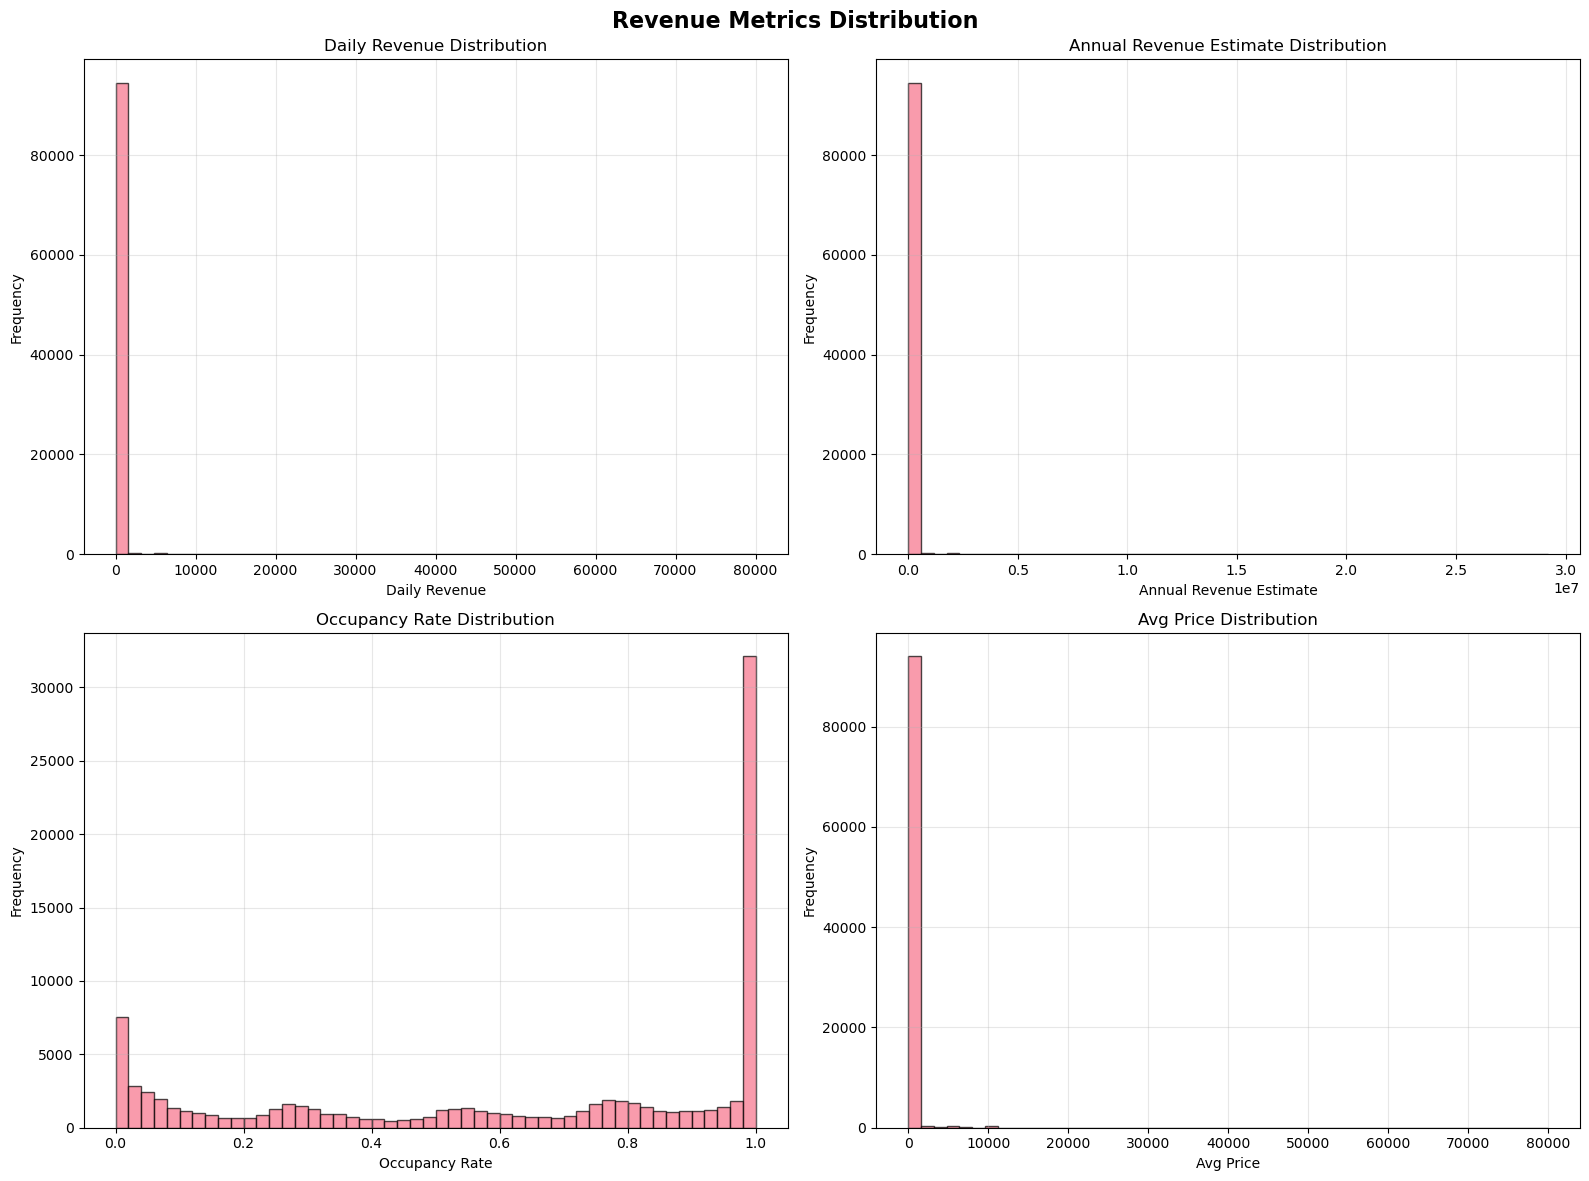

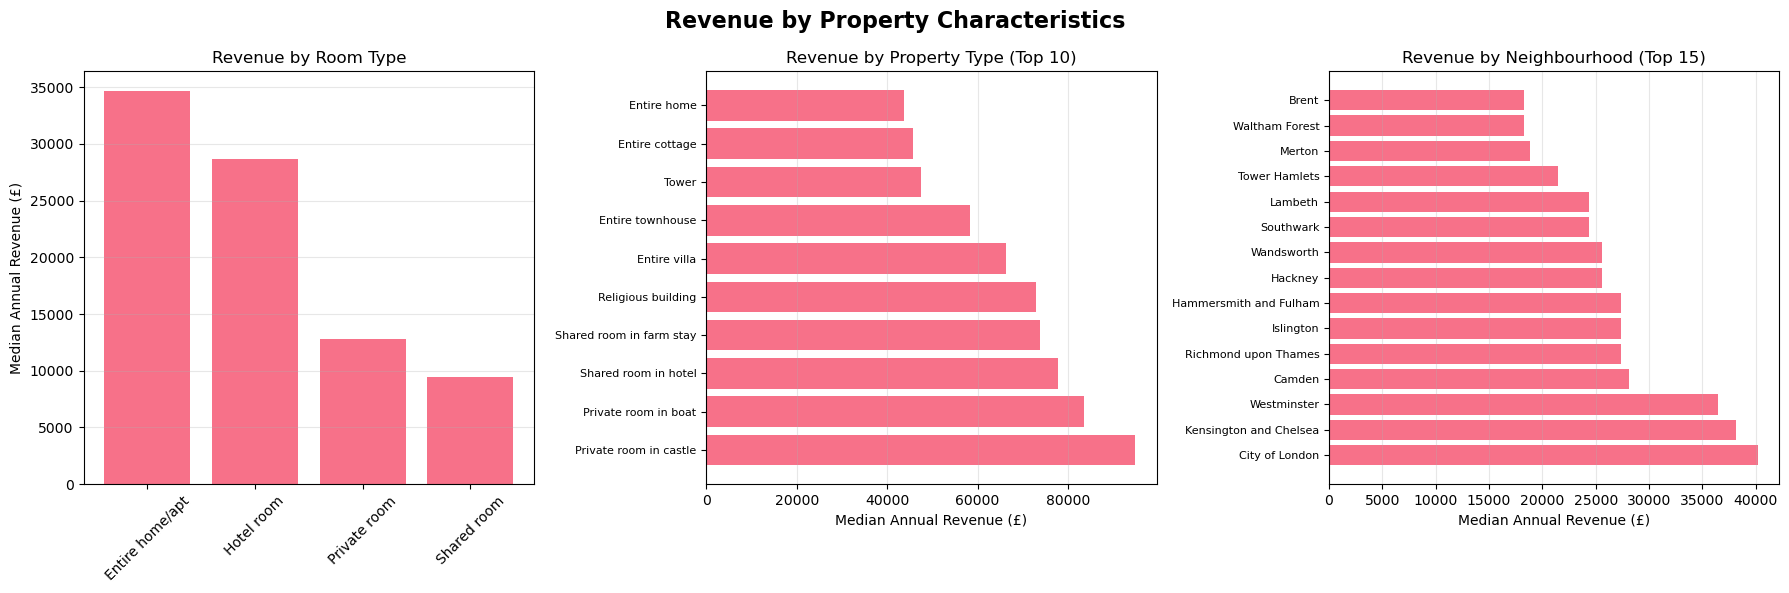

In [10]:
# Analyze revenue metrics if reliable_listings data is available
if has_reliable_data:
    print("REVENUE METRICS ANALYSIS")
    print("=" * 35)

    print(f"Reliable listings for modeling: {len(reliable_listings):,}")

    # Revenue statistics
    revenue_cols = ['daily_revenue', 'annual_revenue_estimate', 'occupancy_rate', 'avg_price']
    available_revenue_cols = [col for col in revenue_cols if col in reliable_listings.columns]

    if available_revenue_cols:
        print("\nRevenue metrics statistics:")
        print(reliable_listings[available_revenue_cols].describe())

        # Visualize revenue metrics
        n_cols = len(available_revenue_cols)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Revenue Metrics Distribution', fontsize=16, fontweight='bold')

        for i, col in enumerate(available_revenue_cols[:4]):
            row, col_idx = i // 2, i % 2
            data = reliable_listings[col].dropna()

            if len(data) > 0:
                axes[row, col_idx].hist(data, bins=50, alpha=0.7, edgecolor='black')
                axes[row, col_idx].set_xlabel(col.replace('_', ' ').title())
                axes[row, col_idx].set_ylabel('Frequency')
                axes[row, col_idx].set_title(f'{col.replace("_", " ").title()} Distribution')
                axes[row, col_idx].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Revenue by property characteristics
        # First, join with listings data to get property features
        revenue_with_features = reliable_listings.merge(
            listings_df[['id', 'room_type', 'property_type', 'neighbourhood_cleansed']],
            left_index=True,
            right_on='id',
            how='left'
        )

        if 'annual_revenue_estimate' in revenue_with_features.columns:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            fig.suptitle('Revenue by Property Characteristics', fontsize=16, fontweight='bold')

            # Revenue by room type
            if 'room_type' in revenue_with_features.columns:
                room_revenue = revenue_with_features.groupby('room_type')['annual_revenue_estimate'].median().sort_values(ascending=False)
                axes[0].bar(range(len(room_revenue)), room_revenue.values)
                axes[0].set_xticks(range(len(room_revenue)))
                axes[0].set_xticklabels(room_revenue.index, rotation=45)
                axes[0].set_ylabel('Median Annual Revenue (£)')
                axes[0].set_title('Revenue by Room Type')
                axes[0].grid(axis='y', alpha=0.3)

            # Revenue by property type (top 10)
            if 'property_type' in revenue_with_features.columns:
                prop_revenue = revenue_with_features.groupby('property_type')['annual_revenue_estimate'].median().sort_values(ascending=False).head(10)
                axes[1].barh(range(len(prop_revenue)), prop_revenue.values)
                axes[1].set_yticks(range(len(prop_revenue)))
                axes[1].set_yticklabels(prop_revenue.index, fontsize=8)
                axes[1].set_xlabel('Median Annual Revenue (£)')
                axes[1].set_title('Revenue by Property Type (Top 10)')
                axes[1].grid(axis='x', alpha=0.3)

            # Revenue by neighbourhood (top 15)
            if 'neighbourhood_cleansed' in revenue_with_features.columns:
                neighbourhood_revenue = revenue_with_features.groupby('neighbourhood_cleansed')['annual_revenue_estimate'].median().sort_values(ascending=False).head(15)
                axes[2].barh(range(len(neighbourhood_revenue)), neighbourhood_revenue.values)
                axes[2].set_yticks(range(len(neighbourhood_revenue)))
                axes[2].set_yticklabels(neighbourhood_revenue.index, fontsize=8)
                axes[2].set_xlabel('Median Annual Revenue (£)')
                axes[2].set_title('Revenue by Neighbourhood (Top 15)')
                axes[2].grid(axis='x', alpha=0.3)

            plt.tight_layout()
            plt.show()
else:
    print("Revenue metrics not available yet - run calendar analysis first")

## 9. Key Insights and Imputation Strategy Recommendations

In [11]:
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("=" * 45)

# Summarize key findings
insights = []

# Missing data insights
high_missing_features = missing_df[missing_df['missing_percentage'] > 20]['feature'].tolist()
if high_missing_features:
    insights.append(f"High missing data (>20%): {', '.join(high_missing_features[:5])}")

# Geographic data
if 'neighbourhood_cleansed' in listings_df.columns:
    neighbourhood_missing_pct = listings_df['neighbourhood_cleansed'].isna().mean() * 100
    insights.append(f"Neighbourhood missing: {neighbourhood_missing_pct:.1f}% - needs reverse geocoding")

# Coordinate availability
if 'latitude' in listings_df.columns and 'longitude' in listings_df.columns:
    coord_missing_pct = (listings_df['latitude'].isna() | listings_df['longitude'].isna()).mean() * 100
    insights.append(f"Coordinates missing: {coord_missing_pct:.1f}%")

# Review data patterns
if 'review_scores_rating' in listings_df.columns:
    review_missing_pct = listings_df['review_scores_rating'].isna().mean() * 100
    insights.append(f"Review scores missing: {review_missing_pct:.1f}% - consider listings without reviews")

print("🔍 KEY INSIGHTS:")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")


KEY INSIGHTS AND RECOMMENDATIONS
🔍 KEY INSIGHTS:
1. High missing data (>20%): beds, price, review_scores_location, review_scores_value, review_scores_checkin
2. Neighbourhood missing: 0.0% - needs reverse geocoding
3. Coordinates missing: 0.0%
4. Review scores missing: 25.7% - consider listings without reviews


## 10. Export Summary for Feature Engineering

Save key findings to guide the feature engineering phase.

In [12]:
# Create summary for feature engineering phase
visualization_summary = {
    'total_listings': len(listings_df),
    'missing_value_analysis': missing_df.to_dict('records'),
    'high_missing_features': missing_df[missing_df['missing_percentage'] > 20]['feature'].tolist(),
    'imputation_priorities': {
        'neighbourhood_cleansed': {
            'missing_percentage': missing_df[missing_df['feature'] == 'neighbourhood_cleansed']['missing_percentage'].iloc[0] if 'neighbourhood_cleansed' in missing_df['feature'].values else 0,
            'strategy': 'reverse_geocoding'
        },
        'review_features': {
            'features': [f for f in available_review_features if 'review_scores' in f],
            'strategy': 'median_with_indicator'
        },
        'property_features': {
            'features': ['bedrooms', 'beds', 'bathrooms_text'],
            'strategy': 'knn_imputation'
        }
    }
}

# Add revenue summary if available
if has_reliable_data and 'annual_revenue_estimate' in reliable_listings.columns:
    visualization_summary['revenue_analysis'] = {
        'reliable_listings_count': len(reliable_listings),
        'revenue_range': {
            'min': float(reliable_listings['annual_revenue_estimate'].min()),
            'max': float(reliable_listings['annual_revenue_estimate'].max()),
            'median': float(reliable_listings['annual_revenue_estimate'].median())
        }
    }

# Save summary
import json
summary_path = '../data/processed/etap2/analysis/visualization_summary.json'
with open(summary_path, 'w') as f:
    json.dump(visualization_summary, f, indent=2)

print(f"Visualization summary saved to: {summary_path}")
print("\n🎉 Comprehensive data visualization complete!")
print("Ready to proceed with informed feature engineering and modeling.")

Visualization summary saved to: ../data/processed/etap2/analysis/visualization_summary.json

🎉 Comprehensive data visualization complete!
Ready to proceed with informed feature engineering and modeling.
